In [1]:
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1e6
N = 100000 # number of samples to simulate
d = 0.5 # half wavelength spacing

Nr = 16 # elements
mu = 1e-4 # Learning rate
theta_soi = np.deg2rad(25)
theta2 = np.deg2rad(-15)
theta3 = np.deg2rad(-10)
theta4 = np.deg2rad(45)

# steering vectors
s1 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_soi)).reshape(-1,1) # Nrx1
s2 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta2)).reshape(-1,1)
s3 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta3)).reshape(-1,1)
s4 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta4)).reshape(-1,1)

# SOI is a Length 127 gold code, repeated
gold_code = np.array([-1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1])
soi_samples_per_symbol = 8
soi = np.repeat(gold_code, soi_samples_per_symbol) # Gold code is 31 bits, so 31*8 = 248 samples
num_sequence_repeats = int(N / soi.shape[0]) + 1 # number of times to repeat the sequence
soi = np.tile(soi, num_sequence_repeats) # repeat the sequence to fill simulated time
soi = soi[:N] # trim to N samples
soi = soi.reshape(1, -1) # 1xN

# Interference, eg tone jammers, from different directions from the SOI
t = np.arange(N)/sample_rate # time vector
tone2 = np.exp(2j*np.pi*0.02e6*t).reshape(1,-1)
tone3 = np.exp(2j*np.pi*0.03e6*t).reshape(1,-1)
tone4 = np.exp(2j*np.pi*0.04e6*t).reshape(1,-1)

# Simulate received signal
r = s1 @ soi + s2 @ tone2 + s3 @ tone3 + s4 @ tone4
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
r = r + 0.5*n # Nr x N

w_lms = np.zeros((Nr, 1), dtype=complex)
error_log = []
# Loop through each sample in the received signal
for n in range(0, N):
    x_n = r[:, n].reshape(-1, 1)  # Current input sample
    y_n = w_lms.conj().T @ x_n  # Calculate filter output
    y_n = y_n.reshape(-1,1)  # make into a column vector
    error_lms = soi[0, n] - y_n   # Calculate error
    error_log.append(np.abs(error_lms)[0,0])  # Store error for plotting
    w_lms += 2*mu * np.conj(error_lms) * x_n

Text(0, 0.5, 'Error [dB]')

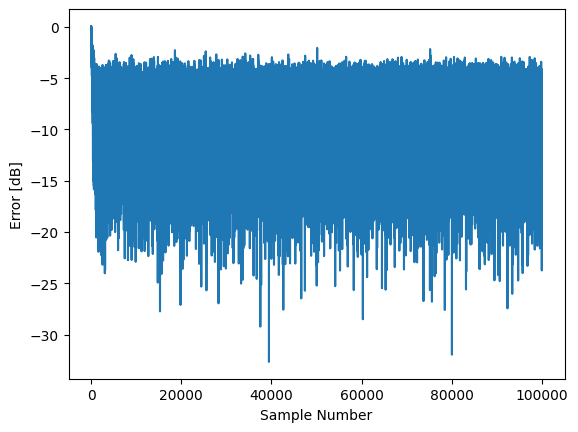

In [2]:
# Plot the error
plt.plot(10*np.log10(error_log))
plt.xlabel('Sample Number')
plt.ylabel('Error [dB]')

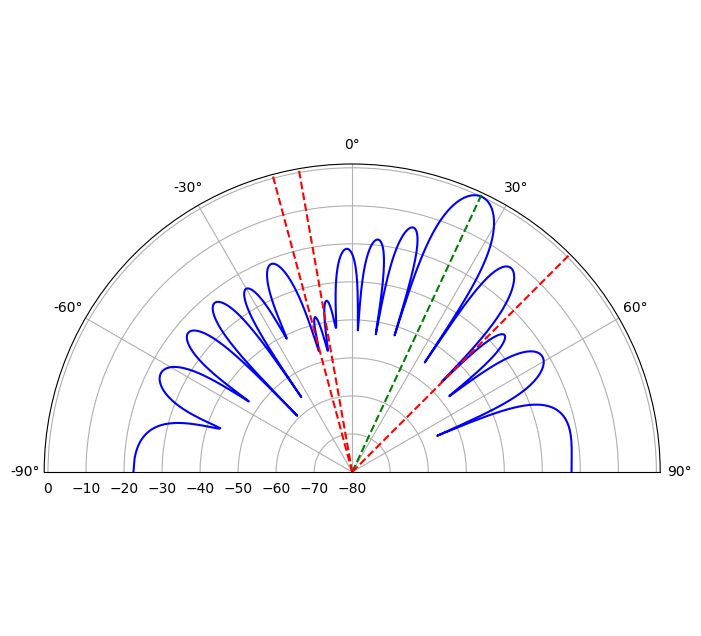

In [3]:
# Plot final LMS beam pattern
w_lms = np.conj(w_lms)
N_fft = 1024
w_soi_lms = w_lms.reshape(-1)  # reshape to row vector
w_padded_lms = np.concatenate((w_soi_lms, np.zeros(N_fft - Nr)))  # zero pad
w_fft_dB_lms = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded_lms)))**2)
w_fft_dB_lms -= np.max(w_fft_dB_lms)  # normalize to 0 dB at peak
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft))  # in radians
ax.plot(theta_bins, w_fft_dB_lms, 'b-', label='LMS')
ax.set_theta_zero_location('N')  # type: ignore # make 0 degrees point up
ax.set_theta_direction(-1) # type: ignore # increase clockwise
ax.set_rlabel_position(100) # type: ignore # Move grid labels
ax.set_thetamin(-90) # type: ignore # only show top half
ax.set_thetamax(90) # type: ignore
ax.set_ylim([-80, 1]) # type: ignore # Set y-axis limits
ax.plot([theta_soi, theta_soi], [-80, 1], 'g--')  # SOI Direction
ax.plot([theta2]*2, [-80, 1], 'r--')
ax.plot([theta3]*2, [-80, 1], 'r--')
ax.plot([theta4]*2, [-80, 1], 'r--')